In [1]:
from molmap import dataset
from molmap import loadmap
import molmap

import matplotlib.pyplot as plt
from joblib import dump, load
from tqdm import tqdm
import pandas as pd
tqdm.pandas(ascii=True)

import numpy as np
import tensorflow as tf

#use the second GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


%matplotlib inline
np.random.seed(777)
tf.set_random_seed(777)


def get_deepchem_idx(df):
    """ deepchem dataset"""
    deepchem_data_name = './SIDER_deepchem.data'
    if os.path.exists(deepchem_data_name):
        train_df,valid_df,test_df = load(deepchem_data_name)
    else:
        import deepchem as dc
        task, train_valid_test, _ = dc.molnet.load_sider(featurizer='Raw',split = 'random')
        train, valid, test = train_valid_test
        train_df = df[df.smiles.isin(train.ids)]
        valid_df = df[df.smiles.isin(valid.ids)]
        test_df = df[df.smiles.isin(test.ids)]
        dump((train_df,valid_df,test_df), deepchem_data_name)
    train_idx = train_df.index
    valid_idx = valid_df.index
    test_idx = test_df.index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx


def get_attentiveFP_idx(df):
    """ attentiveFP dataset"""
    train, valid,test = load('./SIDER_attentiveFP.data')
    print('training set: %s, valid set: %s, test set %s' % (len(train), len(valid), len(test)))
    train_idx = df[df.smiles.isin(train.smiles)].index
    valid_idx = df[df.smiles.isin(valid.smiles)].index
    test_idx = df[df.smiles.isin(test.smiles)].index
    print('training set: %s, valid set: %s, test set %s' % (len(train_idx), len(valid_idx), len(test_idx)))
    return train_idx, valid_idx, test_idx 

def get_pos_weights(trainY):
    """pos_weights: neg_n / pos_n """
    dfY = pd.DataFrame(trainY)
    pos = dfY == 1
    pos_n = pos.sum(axis=0)
    neg = dfY == 0
    neg_n = neg.sum(axis=0)
    pos_weights = (neg_n / pos_n).values
    neg_weights = (pos_n / neg_n).values
    return pos_weights, neg_weights

/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shenwanxiang/anaconda3/envs/deepchem/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shenwanxiang/ana

In [2]:
#load dataset
data = dataset.load_SIDER()
df = data.data

total samples: 1427


In [3]:
MASK = -1
Y = pd.DataFrame(data.y).fillna(MASK).values

In [4]:
# calculate feature
X1_name =  './descriptor_grid_split.data'
X2_name =  './fingerprint_grid_split.data'

if os.path.exists(X1_name):
    X1 = load(X1_name)
else:
    mp = loadmap('../../descriptor_grid_split.mp')
    X1 = mp.batch_transform(data.x, n_jobs = 8)
    dump(X1, X1_name)
    
if os.path.exists(X2_name):
    X2 = load(X2_name)
else:
    mp = loadmap('../../fingerprint_grid_split.mp')
    X2 = mp.batch_transform(data.x, n_jobs = 8)
    dump(X2, X2_name)

In [5]:
#train_idx, valid_idx, test_idx = get_attentiveFP_idx(df)
train_idx, valid_idx, test_idx = get_deepchem_idx(df)


trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]

print(len(train_idx), len(valid_idx), len(test_idx))

training set: 1141, valid set: 143, test set 143
1141 143 143


In [6]:
from loss import cross_entropy, weighted_cross_entropy
from cbks import EarlyStoppingAndPerformance
from model import DoublePathClassificationModel

molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]
pos_weights, neg_weights = get_pos_weights(Y[train_idx])
loss = lambda y_true, y_pred: weighted_cross_entropy(y_true,y_pred, pos_weights, MASK)
model = DoublePathClassificationModel(molmap1_size,molmap2_size, n_outputs = Y.shape[1])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
earlystop = EarlyStoppingAndPerformance((trainX, trainY), (validX, validY), MASK, patience=10, criteria = 'val_auc')
lr = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
model.compile(optimizer = lr, loss = loss)
model.count_params()

784827

In [8]:
model.fit(trainX, trainY, batch_size=128,
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[earlystop]) 

epoch: 0001, loss: 0.6060 - val_loss: 0.5903; auc: 0.5728 - val_auc: 0.5419                                                                                                    
epoch: 0002, loss: 0.6022 - val_loss: 0.5897; auc: 0.5994 - val_auc: 0.5678                                                                                                    
epoch: 0003, loss: 0.6011 - val_loss: 0.5895; auc: 0.6078 - val_auc: 0.5739                                                                                                    
epoch: 0004, loss: 0.6000 - val_loss: 0.5893; auc: 0.6202 - val_auc: 0.5778                                                                                                    
epoch: 0005, loss: 0.5989 - val_loss: 0.5885; auc: 0.6358 - val_auc: 0.5830                                                                                                    
epoch: 0006, loss: 0.5976 - val_loss: 0.5881; auc: 0.6353 - val_auc: 0.5722                                             

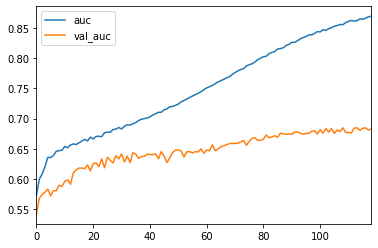

In [13]:
dfp = pd.DataFrame(earlystop.history)[[ 'auc', 'val_auc']]
dfp.plot()

In [11]:
train_auc = np.nanmean(earlystop.evaluate(trainX, trainY))
valid_auc = np.nanmean(earlystop.evaluate(validX, validY))
test_auc = np.nanmean(earlystop.evaluate(testX, testY))


print(train_auc, valid_auc, test_auc)

0.8556826478791948 0.6846483961145772 0.65786148450346


In [12]:
earlystop.evaluate(testX, testY)

[0.6845238095238095,
 0.6068262411347518,
 0.7943262411347518,
 0.6354042214257267,
 0.6952542372881356,
 0.6358135365307037,
 0.887741046831956,
 0.5679271708683473,
 0.6685796269727403,
 0.6188686708860759,
 0.6427842937276899,
 0.6843853820598007,
 0.647189349112426,
 0.5297777777777778,
 0.7129476584022039,
 0.7570247933884299,
 0.6370370370370371,
 0.6684365781710914,
 0.7273182957393484,
 0.48326159732185553,
 0.5815053763440861,
 0.733458177278402,
 0.4910569105691058,
 0.5694942254082039,
 0.6972789115646257,
 0.7744791666666667,
 0.6295597484276729]